We will be analyzing and predicting temperatures in a few cities using polynomial regression, SVM, and radial basis functions, along with a few other techniques (neural network algorithms specifically). This is based on the article 'An extensive evaluation of seven machine learning methods for rainfall prediction in weather derivatives', but for temp data. First upload the temperature dataset for Anchorage, Alaska. 

Data: Temperatures for 180+ nearly consecutive months from the city of Anchorage, Alaska.
We want to predict temperatures based on past data using a time series model. That's it. 
Models: polynomial regression, support vector machines (regression), multi-layer perceptron (NN), LSTM neural network
Error Metric: RMSE

In [2]:
import pandas as pd
import numpy as np
anchorage = pd.read_csv('anchorage.csv')

Do some data cleaning. Get rid of rows with null values and get rid of extra columns not necessary. 

In [3]:
anchorage = anchorage.dropna(how='any', axis=0)
anchorage = anchorage.drop(columns=['Unnamed: 0', 'City', 'Country', 'Latitude', 'Longitude'])

Switch the time variable (X) to be an array from 0 to 2227. This will make prediction analysis smoother.

In [4]:
anchorage['time'] = np.arange(2153)

In [6]:
neural_netTable = pd.DataFrame(data={'temp':anchorage['AverageTemperature']})
#neural_netvalues = neural_netTable.values
length = len(neural_netTable)

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler = StandardScaler()


train_unscaled = neural_netTable.loc[length-1000:length-200]
test_unscaled = neural_netTable.loc[length-200:length-1]

train = scaler.fit_transform(train_unscaled)
test = scaler.transform(test_unscaled)

x_train = train.flatten()[:-1]
y_train = train.flatten()[1:]
x_test = test.flatten()[:-1]
y_test = test.flatten()[1:]

In [8]:
from numpy import newaxis
x_tr2d = x_train.reshape(-1,1)
x_tr3d = x_tr2d[:, :, newaxis]

x_te2d = x_test.reshape(-1,1)
x_te3d = x_te2d[:, :, newaxis]

Epoch 1/100
800/800 [==============================] - 1s - loss: 0.9508     
Epoch 2/100
800/800 [==============================] - 0s - loss: 0.9279     
Epoch 3/100
800/800 [==============================] - 0s - loss: 0.9070     
Epoch 4/100
800/800 [==============================] - 0s - loss: 0.8827     
Epoch 5/100
800/800 [==============================] - 0s - loss: 0.8617     
Epoch 6/100
800/800 [==============================] - 0s - loss: 0.8420     
Epoch 7/100
800/800 [==============================] - 0s - loss: 0.8214     
Epoch 8/100
800/800 [==============================] - 0s - loss: 0.8011     
Epoch 9/100
800/800 [==============================] - 0s - loss: 0.7806     
Epoch 10/100
800/800 [==============================] - 0s - loss: 0.7590     
Epoch 11/100
800/800 [==============================] - 0s - loss: 0.7405     
Epoch 12/100
800/800 [==============================] - 0s - loss: 0.7216     
Epoch 13/100
800/800 [==============================] - 0s - 

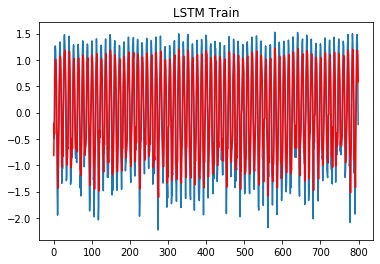

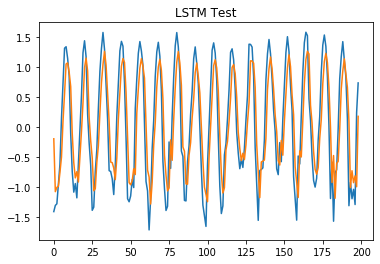

0.5522959253615591


In [10]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import RMSprop
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
from math import sqrt
import matplotlib.pyplot as plt


#unwrapped_x = unwrapped_x2d.reshape((unwrapped_x2d.shape[0], unwrapped_x2d.shape[1], 1))
model = Sequential()
model.add(LSTM(100, activation='tanh', input_shape=(1,1), return_sequences=False))
model.add(Dropout(0.2))
#model.add(Dense(24, input_dim=1, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
model.fit(x_tr3d, y_train, epochs=100, verbose=1, callbacks=[early_stop], shuffle=False, batch_size=300)


plt.plot(y_train)
plt.plot(model.predict(x_tr3d, verbose=10, batch_size=400), color='red')
plt.title('LSTM Train')
plt.show()

#unwrapped_xtest=unwrapped_xtest2d.reshape((unwrapped_xtest2d.shape[0], unwrapped_xtest2d.shape[1], 1))
predictions = model.predict(x_te3d, verbose=2)

plt.plot(y_test)
plt.plot(predictions)
plt.title('LSTM Test')
plt.show()

RMSE = sqrt(mean_squared_error(predictions, y_test))
print(RMSE)

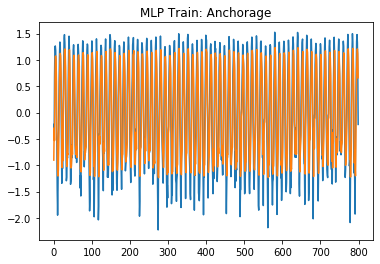

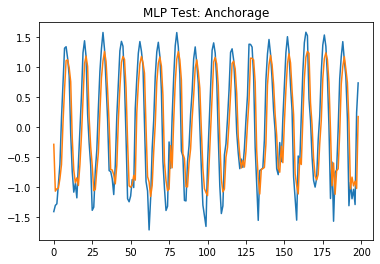

0.548332841869342


In [12]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(solver='lbfgs', activation='tanh', hidden_layer_sizes=(300,150,))
x_train = x_train.reshape(-1,1)
x_test = x_test.reshape(-1,1)
mlp.fit(x_train, y_train)

plt.plot(y_train)
train_predictions = mlp.predict(x_train)
plt.plot(train_predictions)
plt.title('MLP Train: Anchorage')
plt.show()

plt.plot(y_test)
test_predictions = mlp.predict(x_test)
plt.plot(test_predictions)
plt.title('MLP Test: Anchorage')
plt.show()
RMSE2 = sqrt(mean_squared_error(test_predictions, y_test))
print(RMSE2)

Set X to be time and y to be the individual temperatures. Train a polynomial regression model on the existing dataset. But first, plot a scatterplot of all the datapoints before applying any sort of regression line.

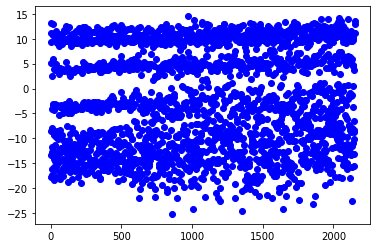

In [123]:
import matplotlib.pyplot as plt
x = anchorage[['time']].values
y = anchorage['AverageTemperature']
plt.scatter(x, y, color='blue')

Looks a bit messy with all of the data accounted for. However, let's just deal with seasonal temperatures. What's interesting to notice is that there were original four 'clusters' representing each season. However as time moves forward, the data converges slightly upwards. To prove this, use a linear regression model to verify. 

In [17]:
from sklearn.linear_model import LinearRegression
linear = LinearRegression()
linear.fit(x, y)
plt.scatter(x, y, color='blue')
plt.plot(x, linear.predict(x), color='red')
print('Rate of temperature increase: ' + str(linear.coef_))

NameError: name 'x' is not defined

Although miniscule, the linear rate is nevertheless positive. It is small due to anomalies and noise not accounted for in the model. To get a better sense (and to hopefully be able to successfully predict temperatures), use the techniques I mention above and subdivide by month. Let's take all January temperatures, for example. 

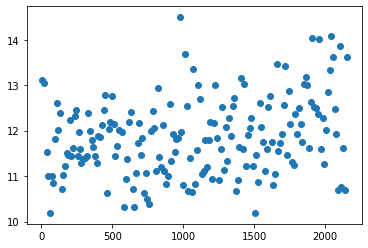

In [32]:
def findmonth(table, num):
    boolean = table['dt'].str.contains('-' + num + '-')
    table[num] = boolean
    table2 = table[table[num] == True]
    return table2[['time', 'AverageTemperature']]
feb = findmonth(anchorage, '07')
x_feb = feb[['time']].values
y_feb = feb['AverageTemperature']
plt.scatter(x_feb, y_feb)

Time to fit a model. First use polynomial regression. Because we want to compare and constrast our efforts in terms of prediction, train the model on everything except for the most recent 5 or so februarys. 

In [33]:
length = len(y_feb)

x_feb_train = np.arange(0,length - 1).reshape(-1, 1)
y_feb_train = feb['AverageTemperature'][0:length-1]

x_feb_test = np.arange(length - 20, length).reshape(-1, 1)
y_feb_test = feb['AverageTemperature'][length-20:length]
assert len(x_feb_test) == len(y_feb_test)

In [34]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
polynomial = PolynomialFeatures(degree=6)
poly_model = polynomial.fit_transform(x_feb_train)
poly = LinearRegression()
poly.fit(poly_model, y_feb_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

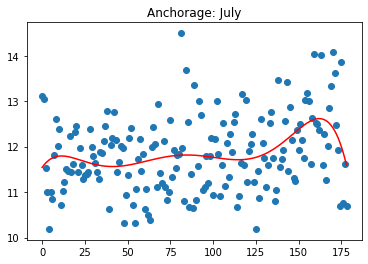

In [36]:

plt.title('Anchorage: July')
plt.scatter(x_feb_train, y_feb_train)
plt.plot(x_feb_train, poly.predict(polynomial.fit_transform(x_feb_train)), color='red')

All in all it looks like that there is much more variance in temperatures as time increases (more extreme temperatures), which is verified by the 10 degree polynomial regression line. While temperatures seem to get hotter, temperatures also seem to get colder and the mean is slightly weighted in favor of the warmer temps. Nevertheless, it shows some back-up that there are elements of climate anomalies. Because polynomial regression is rather limited in power regarding the use of many many datapoints, we don't expect it to perform so well on the predictions (test set). But let's predict anyways. 

In [138]:
predictions = poly.predict(polynomial.fit_transform(x_feb_test))
print(predictions)

[6.20454522 6.35530971 6.52069083 6.70156453 6.89883946 7.11345764
 7.34639524 7.59866326 7.87130829 8.16541324]


Now let's compare with the actual values and find the RMSE.

In [139]:
print(np.array(y_feb_test))

[5.035 2.82  6.572 6.522 6.319 5.386 5.954 6.252 5.979 4.733]


In [140]:
from sklearn.metrics import mean_squared_error
from math import sqrt

RMSE = sqrt(mean_squared_error(y_feb_test, predictions))
print(RMSE)

1.9062006267416656


Now let's use a support vector machine (SVM) to see if we get more promising results. 

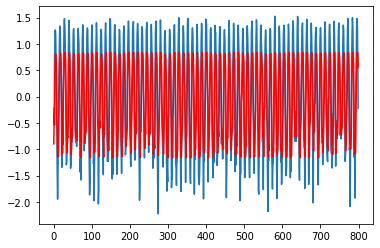

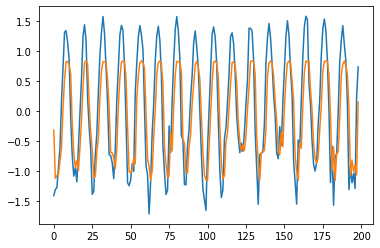

RMSE: 0.5735574366345318


In [27]:

    
    vector_machine = SVR(C=50, cache_size=50, coef0=1.0, degree=6, epsilon=0.8, gamma='auto', \
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.01, verbose=False) 
    vector_machine.fit(x_train, y_train)
    
   
    plt.plot(y_train)
    plt.plot(vector_machine.predict(x_train), color='red')
    plt.show()
    
    plt.plot(y_test)
    plt.plot(vector_machine.predict(x_test))
    plt.show()
    
    predictions = vector_machine.predict(x_test)
   
    RMSE2 = sqrt(mean_squared_error(y_test, predictions))
    print('RMSE: ' + str(RMSE2))
    

It looks like the SVM is more sensitive to the distribution, in which it accounts for the extremes in both colder and warmer Februaries. Use the RMSE as an error metric again, since we're dealing with numerical data to run this on the test data (see above).

Error is much lower than that of the polynomial regression on the same training set. However, the SVM error is consistent across any sort of parameter tuning. It is likely that the model might overfit on existing data, and it is hard to predict the occurrence of temperature anomalies without the addition of other factors/features rather than just temperature alone. However, it is enough to demonstrate that temperature is increasingly fluctuating. 

Another interesting note: when shrinking the training set to data closer to the present, the polynomial model performed WORSE than it being trained on all of the training data, while the SVM performed better with a smaller subset of data. That is, the polynomial model seems to perform better on much larger data while the SVM model learns better on more recent events. Also, having a larger test set seemed to have benefitted the accuracy of the SVM model, but worsened the polynomial model. 

Now, let's try using neural networks. First, turn the time stamps into data more conducive for a supervised-learning model. (Create 3-feature intervals). 

In [144]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()




Try using an MLP neural network.

/srv/app/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


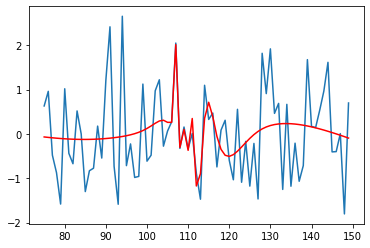

In [145]:
from sklearn.neural_network import MLPRegressor


mlp = MLPRegressor(solver='lbfgs', activation='tanh', hidden_layer_sizes=(500,200,150,50,))

mlp.fit(unwrapped_x, unwrapped_y)

plt.plot(np.arange(75,length), unwrapped_y)
train_predictions = mlp.predict(unwrapped_x)
plt.plot(np.arange(75,length), train_predictions, color='red')
plt.show()

In [146]:
predictions = mlp.predict(unwrapped_xtest)
RMSE = sqrt(mean_squared_error(unwrapped_ytest, predictions))
print(RMSE)

1.0370396963646213


Note that we normalized the data, so it maybe more appropriate to compare this neural network with other similar models (not the two above). The optimal train set size is around ~75 times. Hyperbolic tangent is best as an activation function. 

Now let's try an LSTM (long short-term memory) recurrent neural network. Use Keras. 

Epoch 1/500
Epoch 2/500
Epoch 3/500
Epoch 4/500
Epoch 5/500
Epoch 6/500
Epoch 7/500
Epoch 8/500
Epoch 9/500
Epoch 10/500
Epoch 11/500
Epoch 12/500
Epoch 13/500
Epoch 14/500
Epoch 15/500
Epoch 16/500
Epoch 17/500
Epoch 18/500
Epoch 19/500
Epoch 20/500
Epoch 21/500
Epoch 22/500
Epoch 23/500
Epoch 24/500
Epoch 25/500
Epoch 26/500
Epoch 27/500
Epoch 28/500
Epoch 29/500
Epoch 30/500
Epoch 31/500
Epoch 32/500
Epoch 33/500
Epoch 34/500
Epoch 35/500
Epoch 36/500
Epoch 37/500
Epoch 38/500
Epoch 39/500
Epoch 40/500
Epoch 41/500
Epoch 42/500
Epoch 43/500
Epoch 44/500
Epoch 45/500
Epoch 46/500
Epoch 47/500
Epoch 48/500
Epoch 49/500
Epoch 50/500
Epoch 51/500
Epoch 52/500
Epoch 53/500
Epoch 54/500
Epoch 55/500
Epoch 56/500
Epoch 57/500
Epoch 58/500
Epoch 59/500
Epoch 60/500
Epoch 61/500
Epoch 62/500
Epoch 63/500
Epoch 64/500
Epoch 65/500
Epoch 66/500
Epoch 67/500
Epoch 68/500
Epoch 69/500
Epoch 70/500
Epoch 71/500
Epoch 72/500
Epoch 73/500
Epoch 74/500
Epoch 75/500
Epoch 76/500
Epoch 77/500
Epoch 78

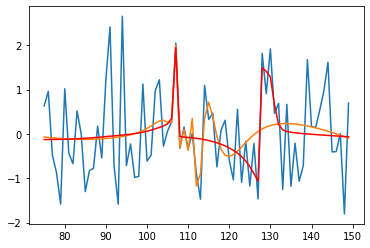

In [147]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
unwrapped_x = unwrapped_x.reshape((unwrapped_x.shape[0], unwrapped_x.shape[1], 1))
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(15, 1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(unwrapped_x, unwrapped_y, epochs=500, verbose=3, batch_size=300)

plt.plot(np.arange(75,length), unwrapped_y)
plt.plot(np.arange(75,length), train_predictions)
plt.plot(np.arange(75,length), model.predict(unwrapped_x, verbose=0), color='red')
plt.show()

unwrapped_xtest=unwrapped_xtest.reshape((unwrapped_xtest.shape[0], unwrapped_xtest.shape[1], 1))
predictions = model.predict(unwrapped_xtest, verbose=0)

In [148]:
RMSE = sqrt(mean_squared_error(unwrapped_ytest, predictions))
print(RMSE)

0.9567850918257546
